### Multivariate Regression

In most of the real life use cases there will be more than one independent variable, so the concept of having multiple independent variables is called as multivariate regression. The equation take the below form.

y = m_1 x_1 + m_2 x_2 + m_3 x_3 + . . .+ m_n x_n
Where, each independent variable is represented by x’s, and m’s are the corresponding coefficients.

We’ll be using the ‘statsmodels’ Python library to learn the basics of multivariate regression, as it provide more useful statistics results which is helpful from learning perspective. Once you understand the fundamental concepts, you can either use ‘scikit-learn’ or ‘statsmodels’ package as both are efficient.

In [2]:
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor, OLSInfluence

# Updated from sklearn.cross_validation to sklearn.model_selection
from sklearn.model_selection import train_test_split

%matplotlib inline

### IPA Market Data



In [ ]:
# Load data
df = pd.read_csv('Data/IPA_price_2025.csv')
print df.head()

     price  lotsize  bedrooms  bathrms stories driveway recroom fullbase  \
0  42000.0     5850         3        1     two      yes      no      yes   
1  38500.0     4000         2        1     one      yes      no       no   
2  49500.0     3060         3        1     one      yes      no       no   
3  60500.0     6650         3        1     two      yes     yes       no   
4  61000.0     6360         2        1     one      yes      no       no   

  gashw airco  garagepl prefarea  
0    no    no         1       no  
1    no    no         0       no  
2    no    no         0       no  
3    no    no         0       no  
4    no    no         0       no  


### Data preprocessing

Let's build a model to predict the house price (dependent variable), considering rest of the variables as independent variables

Handling categorical variables
- Label Binarizer: This will replace the binary variable text with numeric vales. Lets use this function for the below binary variables of our current data set
    - driveway
    - recroom
    - fullbase
    - gashw
    - airco
    - prefarea

- Label Encoder: This will replace category level with number representation

- One Hot Encoder: This will convert n levels to n-1 new variable, and the new variables will use 1 to indicate the presence of level and 0 for otherwise. Note that before calling OneHotEncoder, we should use LabelEncoder to convert levels to number. Alternatively we can achieve the same using get_dummies of pandas package. This is much efficient to use as we can directly use it on the column with text description without having to convert to numbers first.

In [ ]:
# Convert binary fields to numeric boolean fields
lb = preprocessing.LabelBinarizer()

df.driveway = lb.fit_transform(df.driveway)
df.recroom = lb.fit_transform(df.recroom)
df.fullbase = lb.fit_transform(df.fullbase)
df.gashw = lb.fit_transform(df.gashw)
df.airco = lb.fit_transform(df.airco)
df.prefarea = lb.fit_transform(df.prefarea)

df.head()

,price,lotsize,bedrooms,bathrms,stories,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea
0,42000.0,5850,3,1,two,1,0,1,0,0,1,0
1,38500.0,4000,2,1,one,1,0,0,0,0,0,0
2,49500.0,3060,3,1,one,1,0,0,0,0,0,0
3,60500.0,6650,3,1,two,1,1,0,0,0,0,0
4,61000.0,6360,2,1,one,1,0,0,0,0,0,0


### Create dummy variables

In [ ]:
# Create dummy variables for stories
df_stories = pd.get_dummies(df['stories'], prefix='stories', drop_first=True)

# Join the dummy variables to the main dataframe
df = pd.concat([df, df_stories], axis=1)
del df['stories']
df.head()

,price,lotsize,bedrooms,bathrms,driveway,recroom,fullbase,gashw,airco,garagepl,prefarea,stories_one,stories_three,stories_two
0,42000.0,5850,3,1,1,0,1,0,0,1,0,0.0,0.0,1.0
1,38500.0,4000,2,1,1,0,0,0,0,0,0,1.0,0.0,0.0
2,49500.0,3060,3,1,1,0,0,0,0,0,0,1.0,0.0,0.0
3,60500.0,6650,3,1,1,1,0,0,0,0,0,0.0,0.0,1.0
4,61000.0,6360,2,1,1,0,0,0,0,0,0,1.0,0.0,0.0


### Correlation plot

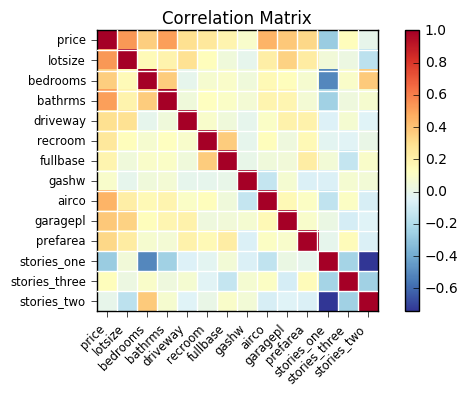

                  price   lotsize  bedrooms   bathrms  driveway   recroom  \
price          1.000000  0.535796  0.366447  0.516719  0.297167  0.254960   
lotsize        0.535796  1.000000  0.151851  0.193833  0.288778  0.140327   
bedrooms       0.366447  0.151851  1.000000  0.373769 -0.011996  0.080492   
bathrms        0.516719  0.193833  0.373769  1.000000  0.041955  0.126892   
driveway       0.297167  0.288778 -0.011996  0.041955  1.000000  0.091959   
recroom        0.254960  0.140327  0.080492  0.126892  0.091959  1.000000   
fullbase       0.186218  0.047487  0.097201  0.102791  0.043428  0.372434   
gashw          0.092837 -0.009201  0.046028  0.067365 -0.011942 -0.010119   
airco          0.453347  0.221765  0.160412  0.184955  0.106290  0.136626   
garagepl       0.383302  0.352872  0.139117  0.178178  0.203682  0.038122   
prefarea       0.329074  0.234782  0.078953  0.064013  0.199378  0.161292   
stories_one   -0.270058  0.054348 -0.509974 -0.250784 -0.053249 -0.022632   

In [ ]:
# lets plot correlation matrix using statmodels graphics packages's plot_corr

# create correlation matrix
corr = df.corr()
sm.graphics.plot_corr(corr, xnames=list(corr.columns))
plt.show()

print corr

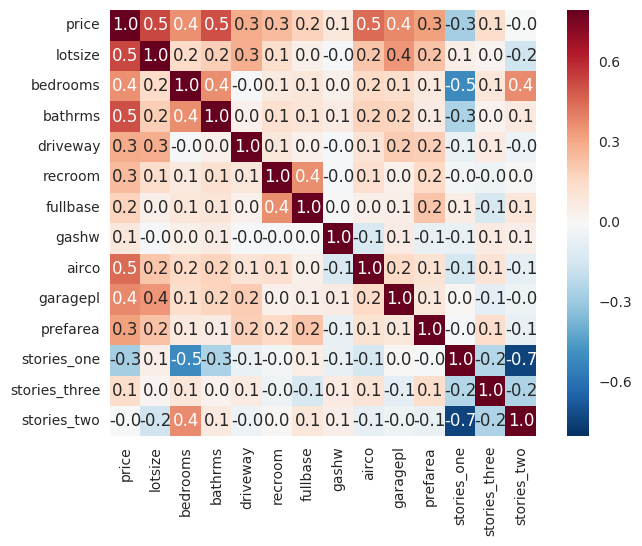

In [ ]:
# Alternatively we can use seaborn package
import seaborn as sns

sns.heatmap(df.corr(), vmax=.8, square=True,annot=True,fmt='.1f')

### Variation Inflation Factor

VIF value of greater than 10 is a indicator of multicollinearity, and these variables should be excluded from the regression model.

In [ ]:
# create a Python list of feature names
independent_variables = ['lotsize', 'bedrooms', 'bathrms','driveway', 'recroom',
                         'fullbase','gashw','airco','garagepl', 'prefarea',
                        'stories_one','stories_two','stories_three']

# use the list to select a subset from original DataFrame
X = df[independent_variables]
y = df['price']

thresh = 10

for i in np.arange(0,len(independent_variables)):
    vif = [variance_inflation_factor(X[independent_variables].values, ix) for ix in range(X[independent_variables].shape[1])]
    maxloc = vif.index(max(vif))
    if max(vif) > thresh:
        print "vif :", vif
        print('dropping \'' + X[independent_variables].columns[maxloc] + '\' at index: ' + str(maxloc))
        del independent_variables[maxloc]
    else:
        break

print 'Final variables:', independent_variables

vif : [8.9580980878443359, 18.469878559519948, 8.9846723472908643, 7.0885785420918861, 1.4770152815033919, 2.013320236472385, 1.1034879198994194, 1.7567462065609025, 1.9826489313438442, 1.5332946465459893, 3.9657526747868612, 5.5117024083548918, 1.7700402770614867]
dropping 'bedrooms' at index: 1
Final variables: ['lotsize', 'bathrms', 'driveway', 'recroom', 'fullbase', 'gashw', 'airco', 'garagepl', 'prefarea', 'stories_one', 'stories_two', 'stories_three']


### Run first iteration of model

We split the data into train/test of 80/20 percent respectively.

In [ ]:
# use the list to select a subset from original DataFrame
X = df[independent_variables]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1)

# create a fitted model
lm = sm.OLS(y_train, X_train).fit()

# print the summary
print lm.summary()

# make predictions on the testing set
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
y_pred = lm.predict(X) # full data
print "Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred)
print "Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print "Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred)
print "Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print "Full Data MAE: ", metrics.mean_absolute_error(y, y_pred)
print "Full Data RMSE: ", np.sqrt(metrics.mean_squared_error(y, y_pred))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     731.3
Date:                Sun, 25 Dec 2016   Prob (F-statistic):          1.46e-274
Time:                        15:33:41   Log-Likelihood:                -4828.1
No. Observations:                 436   AIC:                             9680.
Df Residuals:                     424   BIC:                             9729.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
lotsize           3.8626      0.401      9.629

Lets remove recroom and stories_two has they have p value greater than 0.05 and re-run the model.

In [ ]:
# create a Python list of feature names
independent_variables = ['lotsize', 'bathrms','driveway', 'fullbase','gashw', 'airco','garagepl', 
                         'prefarea','stories_one','stories_three']

# use the list to select a subset from original DataFrame
X = df[independent_variables]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1)

# create a fitted model
lm = sm.OLS(y_train, X_train).fit()

# print the summary
print lm.summary()

# make predictions on the testing set
y_train_pred = lm.predict(X_train)
y_test_pred = lm.predict(X_test)
y_pred = lm.predict(X) # full data
print "Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred)
print "Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print "Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred)
print "Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))

print "Full Data MAE: ", metrics.mean_absolute_error(y, y_pred)
print "Full Data RMSE: ", np.sqrt(metrics.mean_squared_error(y, y_pred))

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.953
Method:                 Least Squares   F-statistic:                     876.8
Date:                Sun, 25 Dec 2016   Prob (F-statistic):          5.12e-277
Time:                        15:33:41   Log-Likelihood:                -4829.2
No. Observations:                 436   AIC:                             9678.
Df Residuals:                     426   BIC:                             9719.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
lotsize           3.9230      0.394      9.965

### Outliers

Plotting normalized residual vs leverage to understand the outlier points.

residual: difference between actual and predicted

leverage: is a measure of how far away the independent variable values of an observation are from those of the other observations

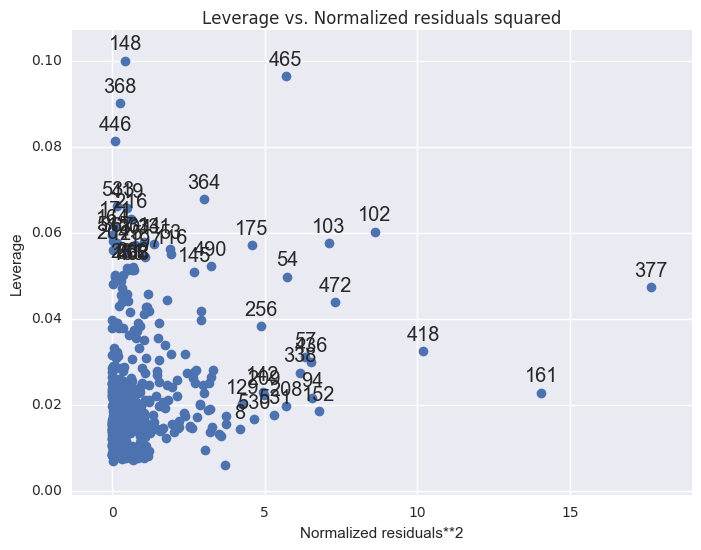

In [ ]:
# lets plot the normalized residual vs leverage
from statsmodels.graphics.regressionplots import plot_leverage_resid2
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(lm, ax = ax)

#### Bonferroni Outlier Test

Bonferroni p-value for the most extreme observation. If the p value is < 0.05 its an outlier.

In [ ]:
# Find outliers #
# Bonferroni outlier test
test = lm.outlier_test()

print 'Bad data points (bonf(p) < 0.05):'
print test[test.icol(2) < 0.05]

Bad data points (bonf(p) < 0.05):
     student_resid   unadj_p   bonf(p)
377       4.387449  0.000014  0.006315


### Residual should be scattered and not have any patterns. The distribution of residual should be normal.

Homoscedasticity and Normality: The error variance should be constant which is known has homoscedasticity and the error should be normally distributed.

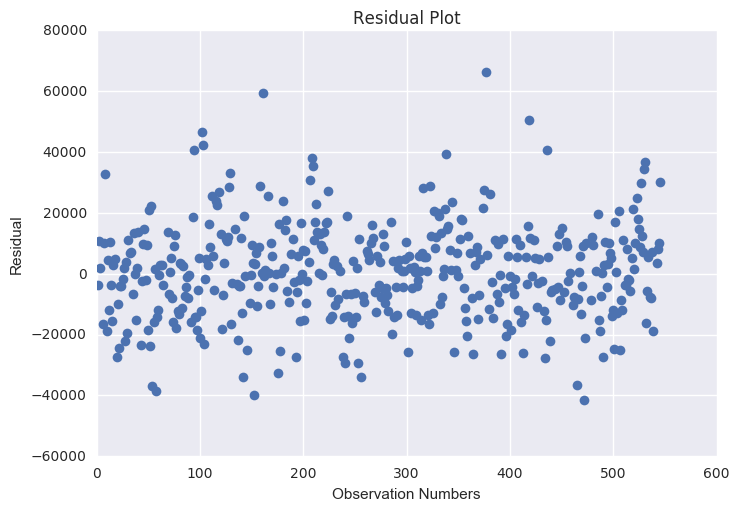

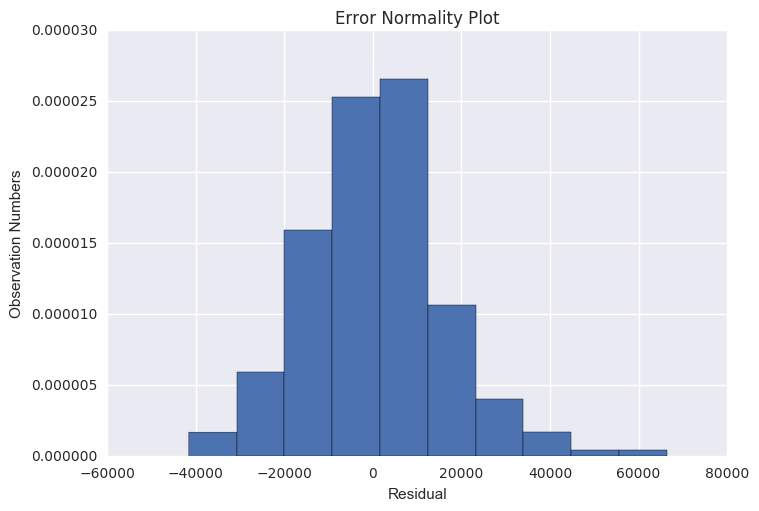

In [ ]:
# plot to check homoscedasticity
plt.plot(lm.resid,'o')
plt.title('Residual Plot')
plt.ylabel('Residual')
plt.xlabel('Observation Numbers')
plt.show()

# normality plot
plt.hist(lm.resid, normed=True)
plt.title('Error Normality Plot')
plt.xlabel('Residual')
plt.ylabel('Observation Numbers')


You can check all the regressors using plot_partregress_grid function.

### if the residual plot is not scattered or not normally distributed then there is a chance that independent variable is not having linear relationship and applying appropriate transformation to the independent variable will fix the issue.

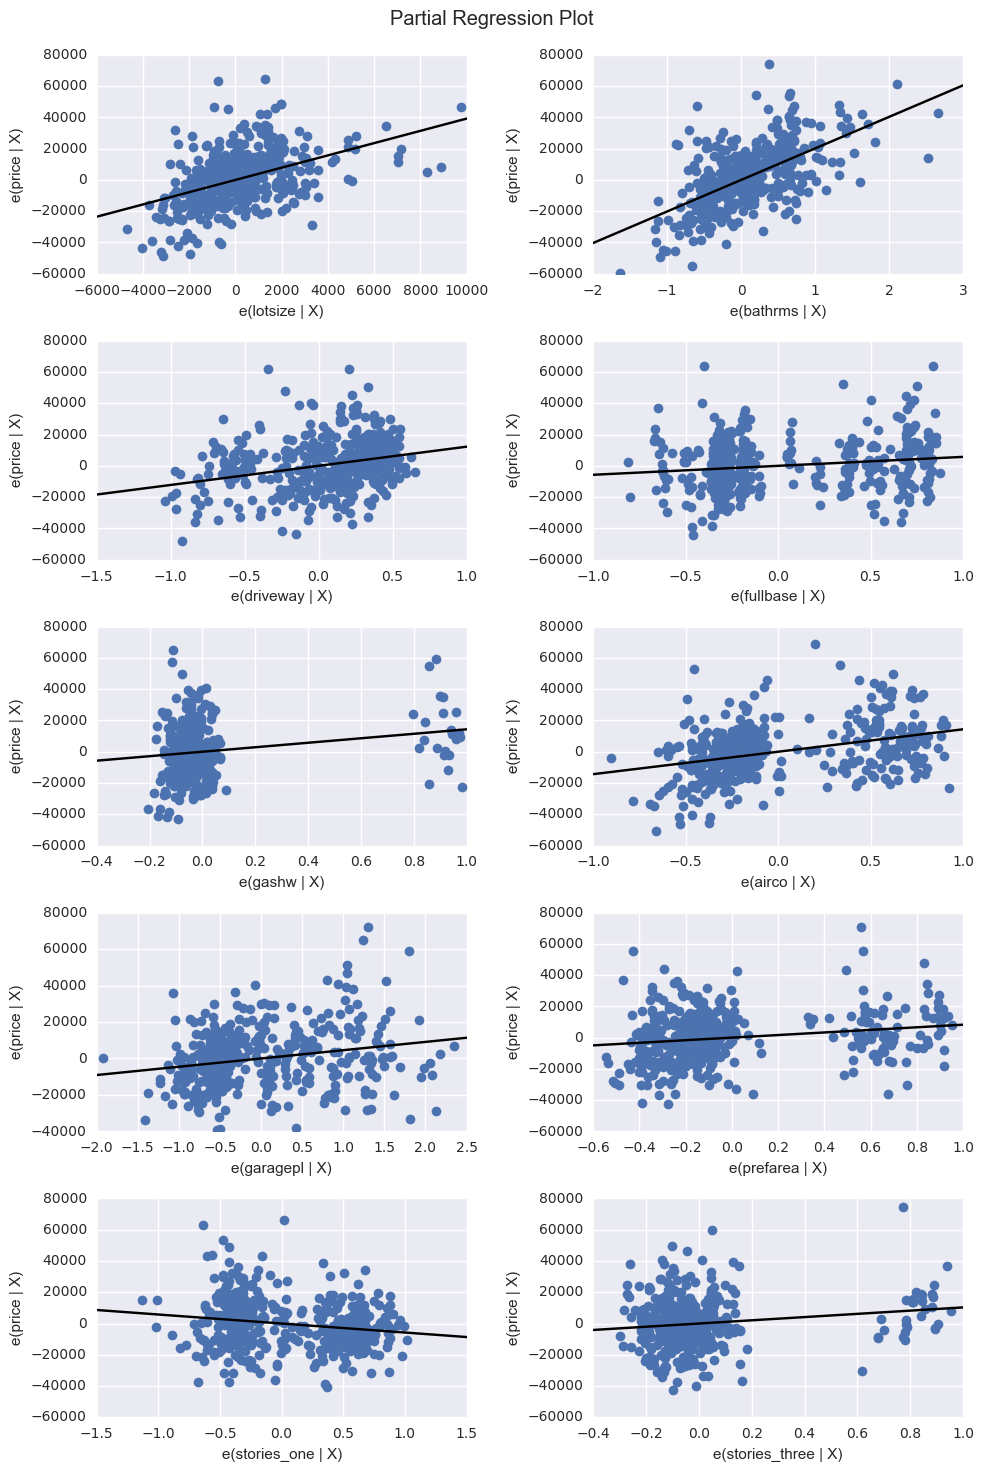

In [ ]:
# linearity plots
fig = plt.figure(figsize=(10,15))
fig = sm.graphics.plot_partregress_grid(lm, fig=fig)

### Regularization

With increase in number of variables and increase in model complexity, the probability of over-fitting. Regularization is a technique to avoid over-fitting problem. Over-fitting occurs when the model fits the data too well capturing all the noises. In this case we can notice a high accuracy in the training data set, whereas the same model will result a low accuracy on test data set. This means the model has fitted the line so well to the train data set that it failed to generalize it to fit well on unseen data set. 

Statsmodel and the scikit-learn provides Ridge and LASSO(Least Absolute Shrinkage and Selection Operator) regression to handle over-fitting issue. With increase in model complexity, the size of coefficients increase exponentially, so the ridge and LASSO regression apply penalty to the magnitude of the co-efficients to handle the issue.  

Ridge Regression: Also known as Tikhonov regularization, use this when you have many of variables that add minor value to the model accuracy individually, however overall improves the model accuracy and can not be excluded form the model. Ridge regression will apply penalty to reduce the magnitude of the coeffecient of all variables that add minor value to the model accuracy. Adds penalty equivalent to square of the magnitude of coefficients, alpha is the regularization strength and must be a positive float. 
 
LASSO: This provides a sparse solution, suitable when you have large set of indepenent variables. The coefficients of the variables that add minor value to the model will be zero. Adds penalty equivalent to absolute value of the magnitude of coefficients. Model complexity decreases with increase in the values of alpha

In [ ]:
from sklearn import linear_model

# Load data
df = pd.read_csv('Data/Grade_Set_2.csv')
df.columns = ['x','y']

for i in range(2,50):              # power of 1 is already there
    colname = 'x_%d'%i              # new var will be x_power
    df[colname] = df['x']**i

independent_variables = list(df.columns)
independent_variables.remove('y')

X= df[independent_variables]       # independent variable
y= df.y                            # dependent variable 

# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.80, random_state=1)

# Ridge regression
lr = linear_model.Ridge(alpha=0.001)
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("------ Ridge Regression ------")
print "Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred)
print "Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print "Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred)
print "Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print "Ridge Coef: ", lr.coef_

# LASSO regression
lr = linear_model.Lasso(alpha=0.001)
lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

print("----- LASSO Regression -----")
print "Train MAE: ", metrics.mean_absolute_error(y_train, y_train_pred)
print "Train RMSE: ", np.sqrt(metrics.mean_squared_error(y_train, y_train_pred))

print "Test MAE: ", metrics.mean_absolute_error(y_test, y_test_pred)
print "Test RMSE: ", np.sqrt(metrics.mean_squared_error(y_test, y_test_pred))
print "LASSO Coef: ", lr.coef_

------ Ridge Regression ------
Train MAE:  12.7753265284
Train RMSE:  16.7206393636
Test MAE:  22.3979435568
Test RMSE:  22.4326420898
Ridge Coef:  [  1.01446487e-88   1.27690319e-87   1.41113660e-86   1.49319913e-85
   1.54589299e-84   1.58049535e-83   1.60336716e-82   1.61825366e-81
   1.62742313e-80   1.63228352e-79   1.63372709e-78   1.63232721e-77
   1.62845333e-76   1.62233965e-75   1.61412730e-74   1.60389073e-73
   1.59165478e-72   1.57740595e-71   1.56110004e-70   1.54266755e-69
   1.52201757e-68   1.49904080e-67   1.47361205e-66   1.44559243e-65
   1.41483164e-64   1.38117029e-63   1.34444272e-62   1.30448024e-61
   1.26111524e-60   1.21418622e-59   1.16354417e-58   1.10906042e-57
   1.05063662e-56   9.88217010e-56   9.21803842e-55   8.51476330e-54
   7.77414158e-53   6.99926407e-52   6.19487106e-51   5.36778815e-50
   4.52745955e-49   3.68659929e-48   2.86198522e-47   2.07542549e-46
   1.35493365e-45   7.36155358e-45   2.64098894e-44  -4.76790286e-45
   2.09597530e-46]
-----